### loading files

In [1]:
import torch
import numpy as np

# Load tensor
labels_tensor = torch.load("C:/Users/nisar/github-classroom/uwa-computer-science/project-12-prototype-bio-acoustic-detection-system-soundsentinel/tensors/labels_tensor.pt")
spikes_tensor = torch.load("C:/Users/nisar/github-classroom/uwa-computer-science/project-12-prototype-bio-acoustic-detection-system-soundsentinel/tensors/spike_data_tensor.pt")

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')

C:\Users\nisar\AppData\Local\Temp\ipykernel_81804\578204215.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels_tensor = torch.load("C:/Users/nisar/github-classroom/u

Original Labels distribution: tensor([1294,   95, 1046,   53,   40], device='cuda:0')


C:\Users\nisar\AppData\Local\Temp\ipykernel_81804\578204215.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spikes_tensor = torch.load("C:/Users/nisar/github-classroom/u

### dataset

In [2]:
import torch
import numpy as np

class CCMKDataset(torch.utils.data.Dataset):
    def __init__(self, spikes_tensor, labels_tensor, target_label=2):
        self.spikes_tensor = spikes_tensor
        self.labels_tensor = labels_tensor
        self.target_label = target_label

        # Step 1: Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]

        # Convert the target label (2) to 1 (positive sample)
        self.labels_tensor[self.labels_tensor == target_label] = 1

        # Step 2: Downsample label 0 (background noise) to match the number of target samples (label 2 -> now 1)
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]

        # print samples
        #print(f"Number of label 0 samples before downsampling: {len(label_0_indices)}")
        #print(f"Number of label 1 samples (after converting target label 2 to 1): {len(label_1_indices)}")

        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False))
        selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False))

        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # print data after samples
        print(f"Number of downsampled label 0 samples: {len(selected_label_0_indices)}")
        print(f"Number of target label 1 samples: {len(selected_label_1_indices)}")
        print(f"Balanced dataset length: {len(balanced_indices)}")

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int())}")

    def __len__(self):
        return len(self.labels_tensor)

    def __getitem__(self, idx):
        return self.spikes_tensor[idx], self.labels_tensor[idx]

dataset = CCMKDataset(spikes_tensor=spikes_tensor, labels_tensor=labels_tensor)

Number of downsampled label 0 samples: 1046
Number of target label 1 samples: 1046
Balanced dataset length: 2092
Filtered Labels distribution after processing: tensor([1046, 1046], device='cuda:0')


### dataloader and split

In [3]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split


# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
# Print the shape of the first sample in the dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check batch information in the train_loader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Calculate and print the labels distribution in each loader

# Training data label distribution
train_labels = torch.cat([batch[1] for batch in train_loader])
print(f'Train Labels distribution: {torch.bincount(train_labels.int())}')

# Validation data label distribution
val_labels = torch.cat([batch[1] for batch in val_loader])
print(f'Validation Labels distribution: {torch.bincount(val_labels.int())}')

# Test data label distribution
test_labels = torch.cat([batch[1] for batch in test_loader])
print(f'Test Labels distribution: {torch.bincount(test_labels.int())}')

Train dataset size: 1672
Test dataset size: 212
Validation dataset size: 208
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Train Labels distribution: tensor([836, 836], device='cuda:0')
Validation Labels distribution: tensor([104, 104], device='cuda:0')
Test Labels distribution: tensor([106, 106], device='cuda:0')


In [7]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 18750937507 (18750937507-uwa). Use `wandb login --relogin` to force relogin


True

In [14]:
import random
import numpy as np
import torch

# Set the random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▃▃▂▃▂▃▁
val_accuracy,▅▄▆██▁▇▇▇▇
val_loss,▁▂▃▄▂▃▆█▄▅
epoch,10
train_loss,0.07729
val_accuracy,0.74519
val_loss,0.36946


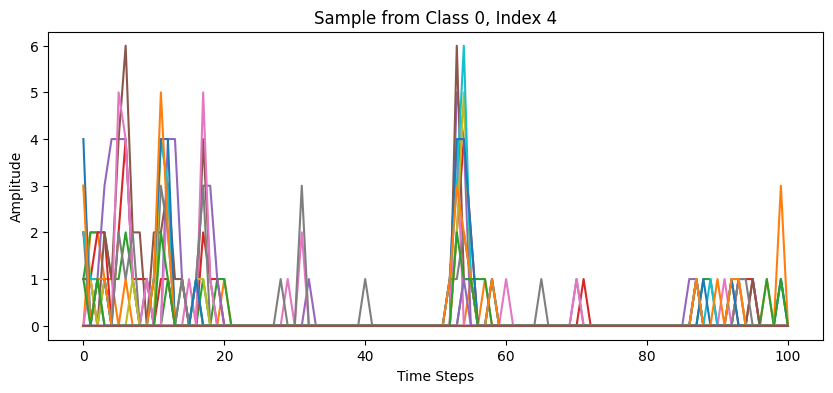

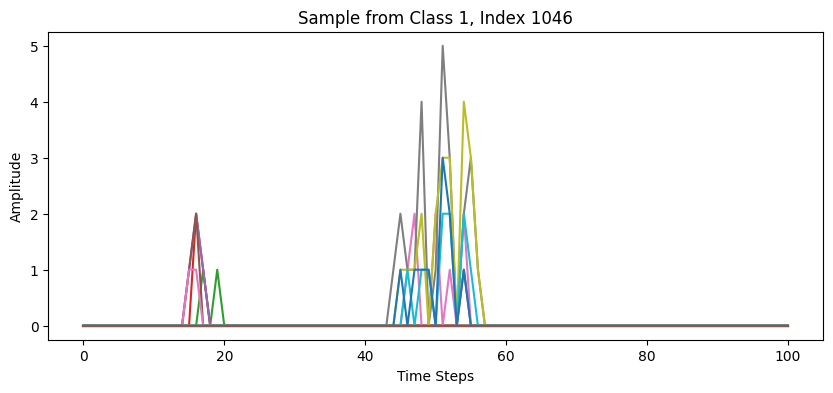

In [68]:
import torch
import matplotlib.pyplot as plt
import wandb


# Initialize WandB project
wandb.init(project="spike-data-visualization")

# Function to visualize a sample and log it to WandB
def visualize_sample(spike_data, label, sample_idx):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(spike_data[sample_idx].cpu().numpy().T)  # Transpose to plot over time
    ax.set_title(f"Sample from Class {label}, Index {sample_idx}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Amplitude')

    # Log figure to WandB
    wandb.log({f"Class_{label}_Sample_{sample_idx}": wandb.Image(fig)})

    # Show the plot locally
    plt.show()

    # Close the figure to avoid memory leakage
    plt.close(fig)

# Choose sample index from class 0 and class 1
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

# Choose specific indices to visualize
sample_idx_0 = label_0_indices[4]  # Specific sample from class 0
sample_idx_1 = label_1_indices[0]  # Specific sample from class 1

# Visualize class 0 sample and log it to WandB
visualize_sample(dataset.spikes_tensor, label=0, sample_idx=sample_idx_0)

# Visualize class 1 sample and log it to WandB
visualize_sample(dataset.spikes_tensor, label=1, sample_idx=sample_idx_1)

# Finish the WandB run
wandb.finish()

## model1

In [17]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from rockpool.nn.networks import SynNet

# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # the output of MSELoss is discrete
n_time = 101     # Number of time steps
batch_size = 32  # Batch size

# Initialize the SynNet model and name it model1
model1 = SynNet(
    p_dropout=0.1,                        # Dropout proportion to use
    n_channels=n_channels,                # Number of input channels
    n_classes=n_classes,                  # Number of output classes (1 for regression)
    size_hidden_layers=[24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
)

print(model1)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [18]:
# Verifying the Layer Structure:
print("All layer names:", model1.lif_names)

All layer names: ['1_LIFTorch', '4_LIFTorch', '7_LIFTorch', '10_LIFTorch']


In [19]:
# Choose device: CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model1.to(device)

# Training loop
for inputs, targets in train_loader:
    # Move inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Transpose inputs to match the expected shape
    inputs = inputs.transpose(1, 2)  # Shape becomes [batch_size, 16, 101]

    # Forward pass
    outputs = model1(inputs)
    print(f"Predicted outputs: {outputs}")
    print(f"True targets: {targets}")
    break  # Only process one batch for now

Predicted outputs: (tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], device='cuda:0', grad_fn=<CopySlices>), {'seq': {'0_LinearTorch': {}, '1_LIFTorch': {'vmem': tensor([ 0.0654, -0.1171,  0.0201, -0.0762, -0.0156, -0.0996, -0.0377, -0.3129,
        -0.0186,  0.0873,  0.0178,  0.1244,  0.0580,  0.0980,  0.0502, -0.1543,
        -0.0349, -0.0118, -0.0207,  0.1651, -0.0256, -0.1442,  0.0328,  0.081

###

checking the result for specific batch

In [20]:
# Choose device: CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model1.to(device)

# Specify the batch you want to process (e.g., 3rd batch has index 2)
target_batch_index = 2

# Training loop with enumeration to find the specific batch
for batch_idx, (inputs, targets) in enumerate(train_loader):
    if batch_idx == target_batch_index:
        # Move inputs and targets to the same device as the model
        inputs, targets = inputs.to(device), targets.to(device)

        # Transpose inputs to match the expected shape
        inputs = inputs.transpose(1, 2)  # Shape becomes [batch_size, 16, 101]

        # Forward pass
        outputs = model1(inputs)
        print(f"Processing Batch {batch_idx + 1}:")
        print(f"Predicted outputs: {outputs}")
        print(f"True targets: {targets}")
        break  # Stop after processing the specified batch


Processing Batch 3:
Predicted outputs: (tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], device='cuda:0', grad_fn=<CopySlices>), {'seq': {'0_LinearTorch': {}, '1_LIFTorch': {'vmem': tensor([ 0.0777, -1.2371,  0.6579, -1.3072, -1.1758, -1.0346, -2.1297, -4.2811,
        -0.2411,  0.1873,  0.0111,  0.8486,  0.3539,  0.5935,  0.3635, -2.8252,
         0.4755,  0.3435, -1.3976,  0.0238, -0.9246, -1.5

Processing Batch 3:
Predicted outputs: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
True targets: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


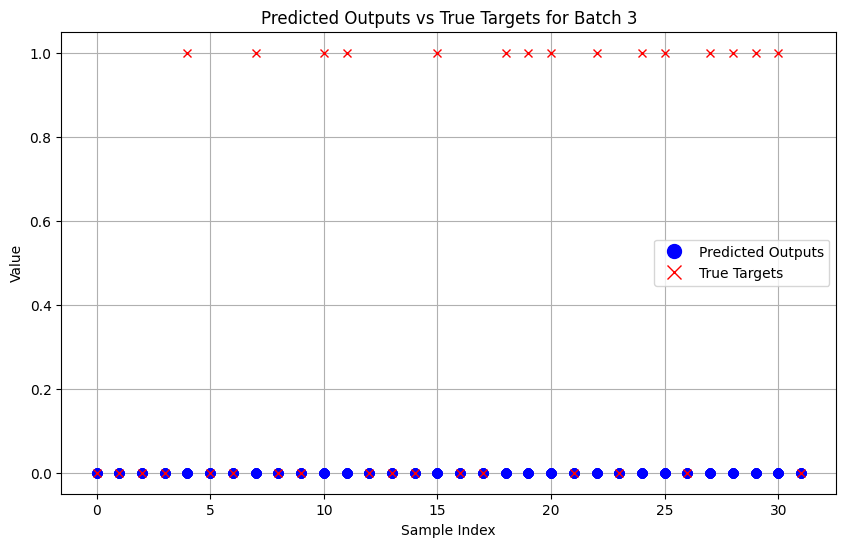

In [31]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Choose device: CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model1.to(device)

# Specify the batch you want to process (e.g., 3rd batch has index 2)
target_batch_index = 2

# Training loop with enumeration to find the specific batch
for batch_idx, (inputs, targets) in enumerate(train_loader):
    if batch_idx == target_batch_index:
        # Move inputs and targets to the same device as the model
        inputs, targets = inputs.to(device), targets.to(device)

        # Transpose inputs to match the expected shape
        inputs = inputs.transpose(1, 2)  # Shape becomes [batch_size, 16, 101]

        # Forward pass
        outputs_tuple = model1(inputs)
        outputs = outputs_tuple[0]
        outputs = outputs.squeeze()  # Remove extra dimensions, if any (e.g., [batch_size, 1] -> [batch_size])

        print(f"Processing Batch {batch_idx + 1}:")
        print(f"Predicted outputs: {outputs}")
        print(f"True targets: {targets}")
        
        # Convert tensors to CPU for plotting
        outputs_cpu = outputs.detach().cpu().numpy()
        targets_cpu = targets.detach().cpu().numpy()


        x_values = range(len(outputs_cpu))

        # Visualization: Compare predicted outputs and true targets
        plt.figure(figsize=(10, 6))
        plt.plot(outputs_cpu, label='Predicted Outputs', marker='o', linestyle='None', color='b')
        plt.plot(targets_cpu, label='True Targets', marker='x', linestyle='None', color='r')

        custom_lines = [
            Line2D([0], [0], color='b', marker='o', linestyle='None', markersize=10, label='Predicted Outputs'),
            Line2D([0], [0], color='r', marker='x', linestyle='None', markersize=10, label='True Targets')
        ]
        plt.legend(handles=custom_lines)  # Use custom markers for the legend


        plt.title(f"Predicted Outputs vs True Targets for Batch {batch_idx + 1}")
        plt.xlabel("Sample Index")
        plt.ylabel("Value")
        plt.grid(True)
        plt.show()

        break

        

### Training the model

In [48]:
# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # the output of MSELoss is discrite
n_time = 101     # Number of time steps
batch_size = 32  # Batch size

# Initialize the SynNet model
model2 = SynNet(
    p_dropout = 0.1,                        # Dropout proportion to use
    n_channels=n_channels,                # Number of input channels
    n_classes=n_classes,                  # Number of output classes (2 for binary classification)
    size_hidden_layers=[32, 32, 32],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
)
print(model2)



SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 32)
        LIFTorch '1_LIFTorch' with shape (32, 32)
        TimeStepDropout '2_TimeStepDropout' with shape (32,)
        LinearTorch '3_LinearTorch' with shape (32, 32)
        LIFTorch '4_LIFTorch' with shape (32, 32)
        TimeStepDropout '5_TimeStepDropout' with shape (32,)
        LinearTorch '6_LinearTorch' with shape (32, 32)
        LIFTorch '7_LIFTorch' with shape (32, 32)
        TimeStepDropout '8_TimeStepDropout' with shape (32,)
        LinearTorch '9_LinearTorch' with shape (32, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [52]:
model2 = model2.to(device)

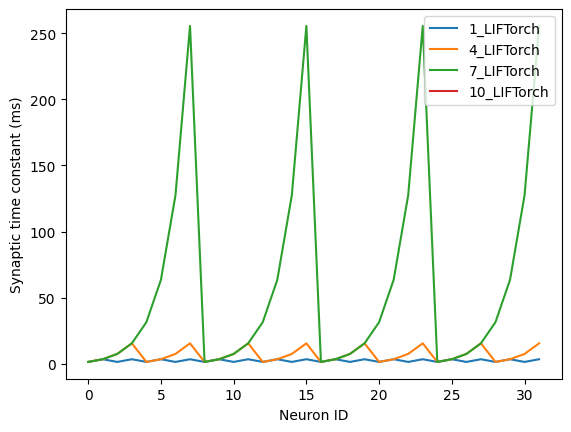

In [64]:
import matplotlib.pyplot as plt

# Plot synaptic time constants for each LIF layer
for lyr_name in model2.lif_names:
    tau_syn = model2.seq[lyr_name].tau_syn.detach().cpu().numpy() / 1e-3  # Convert to ms
    plt.plot(tau_syn, label=f"{lyr_name}")
    
plt.xlabel("Neuron ID")
plt.ylabel("Synaptic time constant (ms)")
plt.legend()
plt.show()

In [37]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# Data augmentation functions

# Time shift function：Shifts the event data along the time axis.
def time_shift(event_data, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift)  # Randomly choose a shift amount
    return np.roll(event_data, shift, axis=0)  # Apply shift along the time axis

# Add noise function：Adds Gaussian noise to event data.
def add_noise(event_data, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, event_data.shape)  # Generate Gaussian noise
    return event_data + noise  # Add noise to the data

# Random drop function：Randomly drops parts of the event data.
def random_drop(event_data, drop_rate=0.1):
    mask = np.random.binomial(1, 1 - drop_rate, event_data.shape)  # Generate a mask to randomly drop parts of the data
    return event_data * mask  # Apply the mask to the data

# Combine augmentation functions
def augment_data(event_data, augmentation_funcs):
    for func in augmentation_funcs:
        event_data = func(event_data)  # Apply each augmentation function in sequence
    return event_data



# Data loader with augmentation applied to label 1 (event call) samples
def augment_train_data(train_loader):
    augmentation_funcs = [time_shift, add_noise, random_drop]  # List of augmentation functions to apply

    for batch_idx, (data, labels) in enumerate(train_loader):
        for i in range(data.shape[0]):  # Iterate over each sample in the batch
            if labels[i] == 1:  # Only augment data with label 1 (event call)
                # Apply augmentations and convert back to torch.Tensor
                augmented_data = augment_data(data[i].cpu().numpy(), augmentation_funcs)  # Apply augmentations
                data[i] = torch.from_numpy(augmented_data).to(data[i].device)  # Ensure the tensor is on the same device (CPU or GPU)
        yield data, labels  # Yield augmented data and labels for training

In [49]:
wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
},name="32layer, augmented_data, outputs.mean,learning_rate=1e-3")

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(model2.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 10

def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.mean(dim=1)

            predictions = torch.round(torch.sigmoid(outputs))  # For binary classification
            correct += (predictions == targets.unsqueeze(1)).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

# Training and Validation loop
for epoch in range(n_epochs):  # Progress bar for epochs
    model2.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in augment_train_data(train_loader): # Use augmented data

        optimizer.zero_grad()  # Clear gradients
        inputs, targets = inputs.to(device), targets.to(device)

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = model2(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.mean(dim=1)  # mean spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model2.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

            # Forward pass through the network
            output, _, _ = model2(inputs)
            output = output.mean(dim=1)  # mean spikes over the time dimension

            # Ensure targets are of float type
            targets = targets.float().unsqueeze(1)

            # Compute validation loss
            loss = loss_fun(output, targets)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(model2, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy  # Log accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# End of training
print('Training completed')



# Final evaluation on test data (to evaluate generalization after training)
test_accuracy = calculate_accuracy(model2, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Optionally save the model using W&B
torch.save(model2.state_dict(), "model_32layer_augmented.pth")
wandb.save("model_32layer_augmented.pth")

# Finish the W&B run
wandb.finish()



Epoch 1/10, Training Loss: 0.41585401403454114, Validation Loss: 0.34420426189899445, Validation Accuracy: 57.21%
Epoch 2/10, Training Loss: 0.3850978033722572, Validation Loss: 0.6602963422025953, Validation Accuracy: 51.44%
Epoch 3/10, Training Loss: 0.3227486585108739, Validation Loss: 0.489239066573126, Validation Accuracy: 55.29%
Epoch 4/10, Training Loss: 0.2472345341207846, Validation Loss: 0.5141425110798862, Validation Accuracy: 52.40%
Epoch 5/10, Training Loss: 0.1839994289121538, Validation Loss: 0.49485870896439466, Validation Accuracy: 57.69%
Epoch 6/10, Training Loss: 0.1380884566537614, Validation Loss: 0.43626939013068167, Validation Accuracy: 66.83%
Epoch 7/10, Training Loss: 0.135092889222334, Validation Loss: 0.3272280730307102, Validation Accuracy: 74.04%
Epoch 8/10, Training Loss: 0.15322749668134833, Validation Loss: 0.2694496922194958, Validation Accuracy: 77.40%
Epoch 9/10, Training Loss: 0.13684562909996734, Validation Loss: 0.34324935930115835, Validation Accu

OSError: [WinError 1314] A required privilege is not held by the client: 'c:\\Users\\nisar\\github-classroom\\uwa-computer-science\\project-12-prototype-bio-acoustic-detection-system-soundsentinel\\angela19sep\\model_32layer_augmented.pth' -> 'c:\\Users\\nisar\\github-classroom\\uwa-computer-science\\project-12-prototype-bio-acoustic-detection-system-soundsentinel\\angela19sep\\wandb\\run-20240927_111118-zpdlwmb8\\files\\model_32layer_augmented.pth'

In [39]:
import torch

# Function to check if a tensor is on CPU or GPU
def check_tensor_device(tensor, tensor_name="tensor"):
    print(f"{tensor_name} is on {tensor.device}")

# Function to check if a model is on CPU or GPU
def check_model_device(model):
    for name, param in model.named_parameters():
        print(f"Parameter {name} is on {param.device}")

In [41]:
check_tensor_device(inputs, "inputs")
check_tensor_device(targets, "targets")
check_tensor_device(outputs, "outputs")

inputs is on cuda:0
targets is on cuda:0
outputs is on cuda:0


In [54]:
def is_model_on_gpu(model):
    # Check if any attribute of the model has a device or is on GPU
    for param in model.parameters():
        if isinstance(param, torch.Tensor):
            return param.device.type == 'cuda'
    return False  # If no tensor found on cuda

# Example usage
if is_model_on_gpu(model2):
    print("model2 is on GPU.")
else:
    print("model2 is on CPU.")

model2 is on CPU.


In [55]:
def calculate_sensitivity_specificity(outputs, targets, threshold=0.5):
    """
    Calculate sensitivity and specificity using predicted outputs and ground truth targets.
    
    Args:
    - outputs (torch.Tensor): Model outputs (probabilities after sigmoid).
    - targets (torch.Tensor): Ground truth binary labels.
    - threshold (float): Custom threshold for converting probabilities to binary predictions.
    
    Returns:
    - sensitivity (float): Sensitivity (Recall).
    - specificity (float): Specificity.
    """
    # Apply the threshold to get binary predictions
    predictions = torch.where(outputs >= threshold, 1, 0)
    
    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
    TP = torch.sum((predictions == 1) & (targets == 1)).item()
    FP = torch.sum((predictions == 1) & (targets == 0)).item()
    TN = torch.sum((predictions == 0) & (targets == 0)).item()
    FN = torch.sum((predictions == 0) & (targets == 1)).item()
    
    # Sensitivity (Recall): TP / (TP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    
    # Specificity: TN / (TN + FP)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    
    return sensitivity, specificity


In [59]:


import wandb

# Initialize a new WandB run within the same project
wandb.init(
    project="18750937507-uwa",  # Keep the same project name
    name="my_new_run_32layer_augmented",  # Unique run name
    config={
        "learning_rate": 1e-3,
        "epochs": 10,
        "batch_size": 32,
    }
)

# Save the model manually
model_path = "model_32layer_augmented.pth"
torch.save(model2.state_dict(), model_path)

# Create a new artifact and manually log the file
artifact = wandb.Artifact('model_32layer_augmented', type='model')
artifact.add_file(model_path)
wandb.log_artifact(artifact)

# Finish the WandB run
wandb.finish()


In [61]:
# Initialize a new WandB run within the same project
wandb.init(
    project="18750937507-uwa",  # Keep the same project name
    name="my_new_run_32layer_augmented",  # Unique run name
    config={
        "learning_rate": 1e-3,
        "epochs": 10,
        "batch_size": 32,
    }
)

# Final test evaluation (replace this part of your code)
model2.eval()  # Set model to evaluation mode
all_outputs = []
all_targets = []

with torch.no_grad():  # Disable gradient calculation for validation/test
    for inputs, targets in test_loader:
        # Ensure inputs and targets are on the correct device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the network
        inputs = inputs.transpose(1, 2)  # Adjust input dimensions if necessary
        outputs, _, _ = model2(inputs)
        outputs = outputs.mean(dim=1)  # Average spikes over time

        # Store outputs and targets
        all_outputs.append(outputs)
        all_targets.append(targets)

# Concatenate all outputs and targets for the entire test set
all_outputs = torch.cat(all_outputs)
all_targets = torch.cat(all_targets)

# Apply sigmoid to the outputs for binary classification
all_outputs = torch.sigmoid(all_outputs)

# Calculate sensitivity and specificity
sensitivity, specificity = calculate_sensitivity_specificity(all_outputs, all_targets)

# Log results to WandB or print them
wandb.log({"test_sensitivity": sensitivity, "test_specificity": specificity})
print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

# Save the model manually
model_path = "model_32layer_augmented.pth"
torch.save(model2.state_dict(), model_path)

# Create a new artifact and manually log the file to WandB
artifact = wandb.Artifact('model_32layer_augmented', type='model')
artifact.add_file(model_path)
wandb.log_artifact(artifact)

# Finish the WandB run
wandb.finish()

Test Sensitivity: 1.0000, Test Specificity: 0.0000


test_sensitivity,▁
test_specificity,▁
test_sensitivity,1
test_specificity,0


In [62]:
def calculate_sensitivity_specificity_at_thresholds(outputs, targets, thresholds):
    """
    Calculate sensitivity and specificity for different thresholds.

    Args:
    - outputs (torch.Tensor): Model output probabilities after applying sigmoid.
    - targets (torch.Tensor): Ground truth binary labels.
    - thresholds (list of floats): Thresholds to apply for binary classification.

    Returns:
    - sensitivities (list of floats): Sensitivity (Recall) values for each threshold.
    - specificities (list of floats): Specificity values for each threshold.
    """
    sensitivities = []
    specificities = []

    for threshold in thresholds:
        # Convert outputs to binary predictions using the threshold
        predictions = torch.where(outputs >= threshold, 1, 0)

        # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
        TP = torch.sum((predictions == 1) & (targets == 1)).item()
        FP = torch.sum((predictions == 1) & (targets == 0)).item()
        TN = torch.sum((predictions == 0) & (targets == 0)).item()
        FN = torch.sum((predictions == 0) & (targets == 1)).item()

        # Sensitivity (Recall): TP / (TP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        sensitivities.append(sensitivity)

        # Specificity: TN / (TN + FP)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        specificities.append(specificity)

    return sensitivities, specificities


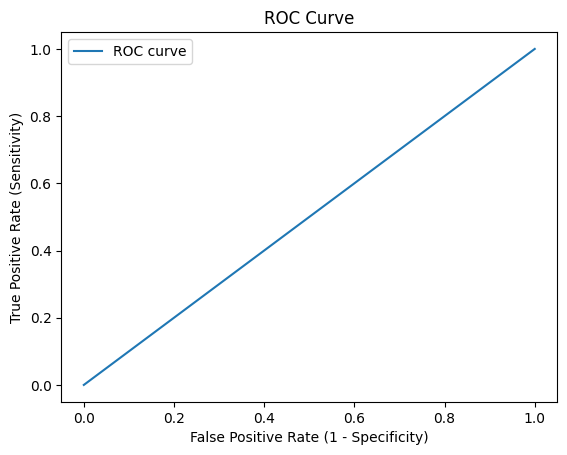

AUC: -0.5000
Test Accuracy: 73.11%


test_accuracy,▁
test_auc,▁
test_accuracy,0.73113
test_auc,-0.5


In [63]:
wandb.init(
    project="18750937507-uwa",  # Keep the same project name
    name="my_new_run_32layer_augmented",  # Unique run name
    config={
        "learning_rate": 1e-3,
        "epochs": 10,
        "batch_size": 32,
    }
)

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(model2.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 10

def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.mean(dim=1)

            predictions = torch.round(torch.sigmoid(outputs))  # For binary classification
            correct += (predictions == targets.unsqueeze(1)).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

# Training and Validation loop
for epoch in range(n_epochs):  # Progress bar for epochs
    model2.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in augment_train_data(train_loader): # Use augmented data

        optimizer.zero_grad()  # Clear gradients
        inputs, targets = inputs.to(device), targets.to(device)

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = model2(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.mean(dim=1)  # mean spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)


# Final test evaluation (replace this part of your code)
model2.eval()  # Set model to evaluation mode
all_outputs = []
all_targets = []

with torch.no_grad():  # Disable gradient calculation for validation/test
    for inputs, targets in test_loader:
        # Ensure inputs and targets are on the correct device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the network
        inputs = inputs.transpose(1, 2)  # Adjust input dimensions if necessary
        outputs, _, _ = model2(inputs)
        outputs = outputs.mean(dim=1)  # Average spikes over time

        # Store outputs and targets
        all_outputs.append(outputs)
        all_targets.append(targets)

# Concatenate all outputs and targets for the entire test set
all_outputs = torch.cat(all_outputs)
all_targets = torch.cat(all_targets)

# Apply sigmoid to the outputs for binary classification
all_outputs = torch.sigmoid(all_outputs)

# Define the thresholds to evaluate (from 0 to 1)
thresholds = np.linspace(0, 1, 100)

# Calculate sensitivity and specificity at different thresholds
sensitivities, specificities = calculate_sensitivity_specificity_at_thresholds(all_outputs, all_targets, thresholds)

# Calculate false positive rate (1 - specificity)
false_positive_rates = [1 - spec for spec in specificities]

# Plot the ROC curve (Sensitivity vs. 1 - Specificity)
plt.plot(false_positive_rates, sensitivities, label='ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate AUC using trapezoidal rule
auc = np.trapz(sensitivities, false_positive_rates)
print(f"AUC: {auc:.4f}")

# Log AUC to W&B
wandb.log({"test_auc": auc})

# Log test accuracy to W&B
test_accuracy = calculate_accuracy(model2, test_loader)
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Optionally save the model using W&B
torch.save(model2.state_dict(), "model_32layer_augmented.pth")
artifact = wandb.Artifact('model_32layer_augmented', type='model')
artifact.add_file("model_32layer_augmented.pth")
wandb.log_artifact(artifact)

# Finish the W&B run
wandb.finish()

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import wandb

# Initialize WandB
wandb.init(
    project="18750937507-uwa",  # Keep the same project name
    name="my_new_run_32layer_augmented",  # Unique run name
    config={
        "learning_rate": 1e-3,
        "epochs": 10,
        "batch_size": 32,
    }
)

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(model2.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()


# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.transpose(1, 2)
            outputs, _, _ = model(inputs)
            outputs = outputs.mean(dim=1)
            predictions = torch.round(torch.sigmoid(outputs))
            correct += (predictions == targets.unsqueeze(1)).sum().item()
            total += targets.size(0)
    return correct / total

# Function to calculate sensitivity and specificity at different thresholds
def calculate_sensitivity_specificity_at_thresholds(outputs, targets, thresholds):
    sensitivities = []
    specificities = []
    for threshold in thresholds:
        predictions = torch.where(outputs >= threshold, 1, 0)
        TP = torch.sum((predictions == 1) & (targets == 1)).item()
        FP = torch.sum((predictions == 1) & (targets == 0)).item()
        TN = torch.sum((predictions == 0) & (targets == 0)).item()
        FN = torch.sum((predictions == 0) & (targets == 1)).item()
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    return sensitivities, specificities

# Training and Validation loop
for epoch in range(n_epochs):
    model2.train()
    epoch_loss = 0.0

    for inputs, targets in augment_train_data(train_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.transpose(1, 2)
        output, _, _ = model2(inputs)
        output = output.mean(dim=1)
        targets = targets.float().unsqueeze(1)
        loss = loss_fun(output, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.transpose(1, 2)
            output, _, _ = model2(inputs)
            output = output.mean(dim=1)
            targets = targets.float().unsqueeze(1)
            loss = loss_fun(output, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = calculate_accuracy(model2, val_loader)

    # Log training and validation losses, accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy
    })

    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Final test evaluation to compute AUC and ROC curve
model2.eval()
all_outputs = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.transpose(1, 2)
        outputs, _, _ = model2(inputs)
        outputs = outputs.mean(dim=1)
        all_outputs.append(outputs)
        all_targets.append(targets)

# Concatenate all outputs and targets for the entire test set
all_outputs = torch.cat(all_outputs)
all_targets = torch.cat(all_targets)
all_outputs = torch.sigmoid(all_outputs)


# Calculate sensitivity and specificity at different thresholds
sensitivities, specificities = calculate_sensitivity_specificity_at_thresholds(all_outputs, all_targets, 0.5)

# Calculate false positive rate
false_positive_rates = [1 - spec for spec in specificities]

# Sort false positive rates and sensitivities
sorted_indices = np.argsort(false_positive_rates)
false_positive_rates = np.array(false_positive_rates)[sorted_indices]
sensitivities = np.array(sensitivities)[sorted_indices]

# Plot ROC curve
plt.plot(false_positive_rates, sensitivities, label='ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate AUC using trapezoidal rule
auc = np.trapz(sensitivities, false_positive_rates)
print(f"AUC: {auc:.4f}")

# Log AUC and test accuracy to W&B
wandb.log({"test_auc": auc})
test_accuracy = calculate_accuracy(model2, test_loader)
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model using W&B
torch.save(model2.state_dict(), "model_32layer_augmented.pth")
artifact = wandb.Artifact('model_32layer_augmented', type='model')
artifact.add_file("model_32layer_augmented.pth")
wandb.log_artifact(artifact)

# Finish the W&B run
wandb.finish()



Epoch 1/10, Training Loss: 0.0992658425052211, Validation Loss: 0.3341041462762015, Validation Accuracy: 70.19%
Epoch 2/10, Training Loss: 0.08233949345237804, Validation Loss: 0.34384146864925114, Validation Accuracy: 66.35%
Epoch 3/10, Training Loss: 0.08156617994437802, Validation Loss: 0.34852720158440725, Validation Accuracy: 74.04%
Epoch 4/10, Training Loss: 0.08275952991449607, Validation Loss: 0.36066622992179226, Validation Accuracy: 78.37%
Epoch 5/10, Training Loss: 0.08371919063183497, Validation Loss: 0.34483401264463154, Validation Accuracy: 77.88%
Epoch 6/10, Training Loss: 0.08142271964758072, Validation Loss: 0.35045540558972527, Validation Accuracy: 58.65%
Epoch 7/10, Training Loss: 0.08414049819111824, Validation Loss: 0.3744131409163986, Validation Accuracy: 74.52%
Epoch 8/10, Training Loss: 0.08134942839168152, Validation Loss: 0.39202520637107746, Validation Accuracy: 75.48%
Epoch 9/10, Training Loss: 0.08502843006039565, Validation Loss: 0.35606147082788603, Valid

TypeError: 'float' object is not iterable